# useful variables

In [35]:
data_root = './data'
zip_path = 'ER-20230510T131934Z-001.zip'
models_dir = './models'

data_path = './data/ER'
initial_without_surprised_annotation_filepath = data_path + '/labels_without_surprised.txt'
processed_without_surprised_annotation_filepath_train = data_path + '/labels_without_surprised_processed_train.txt'
processed_without_surprised_annotation_filepath_valid = data_path + '/labels_without_surprised_processed_valid.txt'

initial_with_surprised_annotation_filepath = data_path + '/labels_with_surprised.txt'
processed_with_surprised_annotation_filepath_train = data_path + '/labels_with_surprised_processed_train.txt'
processed_with_surprised_annotation_filepath_valid = data_path + '/labels_with_surprised_processed_valid.txt'

img_size = 224
batch_size = 32
epochs = 15

# unzipping

In [36]:
import zipfile
import os

if os.path.exists(data_root) and len(os.listdir(data_root)) != 0:
    print('!data was already extracted')
    pass
else:
    os.mkdir(data_root)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)

!data was already extracted


In [37]:
counter = 0

if os.path.exists(processed_without_surprised_annotation_filepath_train) and \
                      len(open(processed_without_surprised_annotation_filepath_train, 'r').readlines()) != 0:
    print('!data was already processed')
    pass
else:
    with open(initial_without_surprised_annotation_filepath, 'r') as initial_file:
        with open(processed_without_surprised_annotation_filepath_train, 'w') as processed_file_train:
            with open(processed_without_surprised_annotation_filepath_valid, 'w') as processed_file_valid:
                for index, line in enumerate(initial_file.readlines()):
                    values = line.split(' ')
                    image_name = values[0]
                    label = values[1]
                    if index < 465:
                        image_dir = image_name.split('_')[1] + '_ER_new_all'
                    else:
                        image_dir = image_name.split('_')[1] + '_ER_all'

                    image_name = image_dir + '/' + image_name + '.jpg'

                    if counter < 8:
                        processed_file_train.write(image_name + ' ' + label)
                        counter += 1
                    elif 8 <= counter < 10:
                        processed_file_valid.write(image_name + ' ' + label)
                        counter += 1
                    elif counter >= 10:
                        counter = 0

!data was already processed


In [38]:
if os.path.exists(processed_with_surprised_annotation_filepath_train) and \
                      len(open(processed_with_surprised_annotation_filepath_train, 'r').readlines()) != 0:
    print('!data was already processed')
    pass
else:
    with open(initial_with_surprised_annotation_filepath, 'r') as initial_file:
        with open(processed_with_surprised_annotation_filepath_train, 'w') as processed_file_train:
            with open(processed_with_surprised_annotation_filepath_valid, 'w') as processed_file_valid:
                for index, line in enumerate(initial_file.readlines()):
                    values = line.split(' ')
                    image_name = values[0]
                    label = values[1]
                    if index < 465:
                        image_dir = image_name.split('_')[1] + '_ER_new_all'
                    else:
                        image_dir = image_name.split('_')[1] + '_ER_all'

                    image_name = image_dir + '/' + image_name + '.jpg'

                    if counter < 8:
                        processed_file_train.write(image_name + ' ' + label)
                        counter += 1
                    elif 8 <= counter < 10:
                        processed_file_valid.write(image_name + ' ' + label)
                        counter += 1
                    elif counter >= 10:
                        counter = 0

# imports

In [39]:
import numpy as np
import math
import random

import timm
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.optimizer import Optimizer
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from timm.loss import AsymmetricLossSingleLabel
import facenet_pytorch
from facenet_pytorch import MTCNN
from torch.quantization import QuantStub, DeQuantStub
from torchmetrics import HingeLoss, F1Score

from PIL import Image
from PIL import ImageFile
import cv2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import sklearn

import sys
import warnings
import copy
import pandas as pd
warnings.filterwarnings('ignore')

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Connected device is {device}')

Connected device is cuda


In [41]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(1996)

# model

In [42]:
models = os.listdir(models_dir)
print(f'available models: {models}')

available models: ['enetb0_classifier.pt', 'enetb0_without_surprised.pt', 'enetb2_classifier.pt', 'enetb2_without_surprised.pt', 'enet_b0_8_va_mtl.pt', 'enet_b2_8_best.pt']


In [43]:
class EmoRecModel(nn.Module):
    def __init__(self, model_path: str):
        super().__init__()
        self.model = torch.load(model_path)
        model_last_layer_input = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.classifier = nn.Linear(model_last_layer_input, 3)
        self.model.eval()
        
    def forward(self, image):
        with torch.no_grad():
            features = self.model(image)
        
        output = self.classifier(features)
        
        return output

In [44]:
enet_b0_path = models_dir + '/' + models[-2]
enet_b2_path = models_dir + '/' + models[-1]

enet_b0_based = EmoRecModel(enet_b0_path).to(device)
enet_b0_based_optimizer = torch.optim.Adam(enet_b0_based.parameters(), lr=1e-3)
enet_b2_based = EmoRecModel(enet_b2_path).to(device)
enet_b2_based_optimizer = torch.optim.Adam(enet_b2_based.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

# data

In [45]:
labels = [file for file in os.listdir(data_path) if '.txt' in file]
print(f'labels:\n\
{labels[0]} - contains data, where surprised was not included,\n\
{labels[1]} - contains data, where surprised was included.')

labels:
labels_without_surprised.txt - contains data, where surprised was not included,
labels_without_surprised_processed_train.txt - contains data, where surprised was included.


In [46]:
transform_train = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.RandomHorizontalFlip(p=0.5),      
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.Resize([img_size, img_size]), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [47]:
idx2class = {0: 'unhappy', 1: 'happy', 2: 'neutral'}

class HSERecEmoDataset(Dataset):
    def __init__(self, annotation_filepath: str, transforms: transforms):
        super().__init__()
        self.annotation_filepath = annotation_filepath
        self.transforms = transforms
        self.images_names = []
        self.labels = []
        self.transforms = transforms
        
        self.define_data()
    
    def define_data(self):
        with open(self.annotation_filepath, 'r') as annotation_file:
            for line in annotation_file.readlines():
                values = line.split(' ')
                image_name = data_path + '/' + values[0]
                label = values[1]
                label = int(label.replace('\n', ''))
                
                self.images_names.append(image_name)
                self.labels.append(label)
    
    def __getitem__(self, index):
        image_name = self.images_names[index]
        image = Image.open(image_name)
        label = self.labels[index]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label
    
    def __len__(self):
        length = len(self.images_names)
        
        return length

In [54]:
ER_traindataset = HSERecEmoDataset(annotation_filepath=processed_without_surprised_annotation_filepath_train,
    transforms=transform_train)
ER_validdataset = HSERecEmoDataset(annotation_filepath=processed_without_surprised_annotation_filepath_valid,
    transforms=transform_valid)

ER_trainloader = DataLoader(ER_traindataset, batch_size=batch_size, shuffle=True)
ER_validloader = DataLoader(ER_validdataset, batch_size=len(ER_validdataset), shuffle=False)

# utils

In [55]:
def train_one_epoch(model, criterion, optimizer, trainloader):
    epoch_loss = 0
    model.train()
    
    for i, (batch_images, batch_labels) in enumerate(trainloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        
        batch_prediction = model(batch_images)
#         _, batch_prediction_ = torch.max(batch_prediction.data, 1)
        batch_prediction_ = torch.argmax(batch_prediction.data, 1)
        
        if i == 0:
            epoch_prediction = batch_prediction_
            epoch_labels = batch_labels
        else:
            epoch_prediction = torch.concat((epoch_prediction, batch_prediction_), dim=0)
            epoch_labels = torch.concat((epoch_labels, batch_labels), dim=0)
        
        iteration_loss = criterion(batch_prediction, batch_labels)
        iteration_loss.backward()
        epoch_loss += iteration_loss.item()
        loss_trace.append(iteration_loss.item())
        optimizer.step()
    
    ground_truth = epoch_labels.clone().cpu().detach().numpy()
    prediction = epoch_prediction.clone().cpu().detach().numpy()
    
    epoch_f1 = f1_score(ground_truth, prediction, average='macro')
    epoch_accuracy = accuracy_score(ground_truth, prediction)
    epoch_precision = precision_score(ground_truth, prediction, average='micro')
    epoch_recall = recall_score(ground_truth, prediction, average='micro')
    epoch_loss /= len(trainloader)
    
    print(f'train evaluations: f1: {epoch_f1:.3f}, accuracy: {epoch_accuracy:.3f}, \
precision (micro): {epoch_precision:.3f}, recall (micro): {epoch_recall:.3f}, loss: {epoch_loss:.3f}')
    
    return epoch_loss

In [56]:
def validate_one_epoch(model, criterion, validloader):
    epoch_loss = 0
    model.eval()
    
    for i, (batch_images, batch_labels) in enumerate(validloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        batch_prediction = model(batch_images)
#         _, batch_prediction_ = torch.max(batch_prediction.data, 1)
        batch_prediction_ = torch.argmax(batch_prediction.data, 1)

        
        if i == 0:
            epoch_prediction = batch_prediction_
            epoch_labels = batch_labels
        else:
            epoch_prediction = torch.concat((epoch_prediction, batch_prediction_), dim=0)
            epoch_labels = torch.concat((epoch_labels, batch_labels), dim=0)
        
        iteration_loss = criterion(batch_prediction, batch_labels)
        epoch_loss += iteration_loss.item()
    
    ground_truth = epoch_labels.clone().cpu().detach().numpy()
    prediction = epoch_prediction.clone().cpu().detach().numpy()
    
    epoch_f1 = f1_score(ground_truth, prediction, average='macro')
    epoch_accuracy = accuracy_score(ground_truth, prediction)
    epoch_precision = precision_score(ground_truth, prediction, average='micro')
    epoch_recall = recall_score(ground_truth, prediction, average='micro')
    epoch_loss /= len(validloader)
    
    print(f'validation evaluations: f1: {epoch_f1:.3f}, accuracy: {epoch_accuracy:.3f}, \
precision (micro): {epoch_precision:.3f}, recall (micro): {epoch_recall:.3f}, loss: {epoch_loss:.3f}')

In [57]:
def plot_loss(loss_trace: list, model_name):
    epochs = np.arange(len(loss_trace))
    plt.figure(figsize=(16, 8))
    plt.plot(epochs, loss_trace, label='Cross-Entropy Loss', color='r')
    plt.grid(True)
    plt.title(f'Cross-Entropy Loss over epochs ({model_name})', weight='bold')
    plt.legend(loc='upper left')
    
    plt.show()

In [58]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
def plt_conf_matrix(y_true,y_pred,filename=None):
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None]
                         , index = [i for i in idx2class.values()],
                         columns = [i for i in idx2class.values()])
    plt.figure(figsize = (10,6))
    ax = sns.heatmap(df_cm, annot=True, linewidth=0, cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted Class", ylabel="True Class")

In [59]:
def get_report(model, validloader):
    for i, (batch_images, batch_labels) in enumerate(validloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        batch_prediction = model(batch_images)
        batch_prediction_ = torch.argmax(batch_prediction.data, 1)

        
        if i == 0:
            epoch_prediction = batch_prediction_
            epoch_labels = batch_labels
        else:
            epoch_prediction = torch.concat((epoch_prediction, batch_prediction_), dim=0)
            epoch_labels = torch.concat((epoch_labels, batch_labels), dim=0)
    
    ground_truth = epoch_labels.clone().cpu().detach().numpy()
    prediction = epoch_prediction.clone().cpu().detach().numpy()
    accuracy = accuracy_score(ground_truth, prediction)
    
    print(sklearn.metrics.classification_report(ground_truth, prediction))
    print(f'accuracy: {accuracy:.3f}')
    plt_conf_matrix(ground_truth, prediction)

# train and evaluate

## EfficientNet-B0

In [60]:
loss_trace = []

for epoch in tqdm(range(epochs)):
    if epoch in range(9):
        print(f'epoch №0{epoch+1} is currently running...')
    else:
        print(f'epoch №{epoch+1} is currently running...')
        
    epoch_loss = train_one_epoch(model=enet_b0_based, criterion=criterion, optimizer=enet_b0_based_optimizer,
        trainloader=ER_trainloader)
    
    if epoch % 5 == 0:
        validate_one_epoch(model=enet_b0_based, criterion=criterion, validloader=ER_validloader)
    
    loss_trace.append(epoch_loss)
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

epoch №01 is currently running...
train evaluations: f1: 0.798, accuracy: 0.784, precision (micro): 0.784, recall (micro): 0.784, loss: 0.814
validation evaluations: f1: 0.923, accuracy: 0.912, precision (micro): 0.912, recall (micro): 0.912, loss: 0.538

epoch №02 is currently running...
train evaluations: f1: 0.893, accuracy: 0.880, precision (micro): 0.880, recall (micro): 0.880, loss: 0.506

epoch №03 is currently running...
train evaluations: f1: 0.893, accuracy: 0.878, precision (micro): 0.878, recall (micro): 0.878, loss: 0.406

epoch №04 is currently running...
train evaluations: f1: 0.901, accuracy: 0.888, precision (micro): 0.888, recall (micro): 0.888, loss: 0.354

epoch №05 is currently running...
train evaluations: f1: 0.916, accuracy: 0.904, precision (micro): 0.904, recall (micro): 0.904, loss: 0.305

epoch №06 is currently running...
train evaluations: f1: 0.926, accuracy: 0.917, precision (micro): 0.917, recall (micro): 0.917, loss: 0.279
validation evaluations: f1: 0.

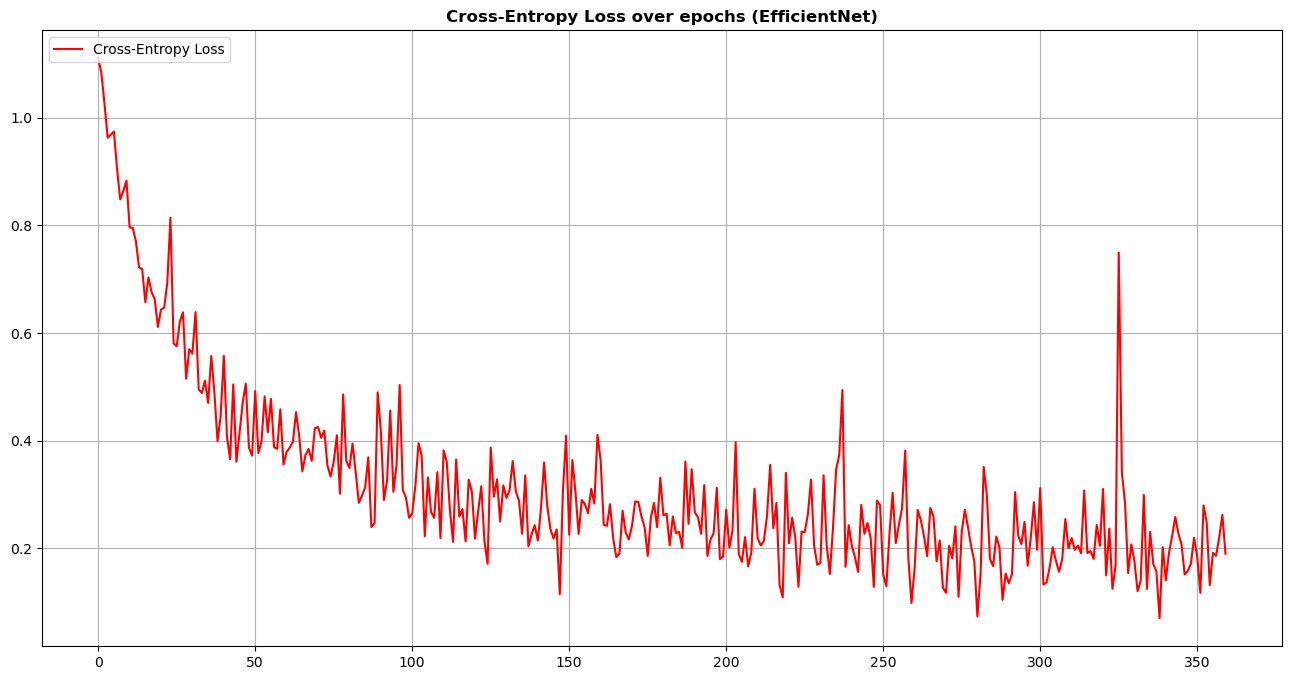

In [61]:
plot_loss(loss_trace=loss_trace, model_name=enet_b0_based.model.__class__.__name__)

### validation report

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        72
           1       1.00      0.97      0.99        40
           2       0.92      0.97      0.94        70

    accuracy                           0.96       182
   macro avg       0.96      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182

accuracy: 0.956


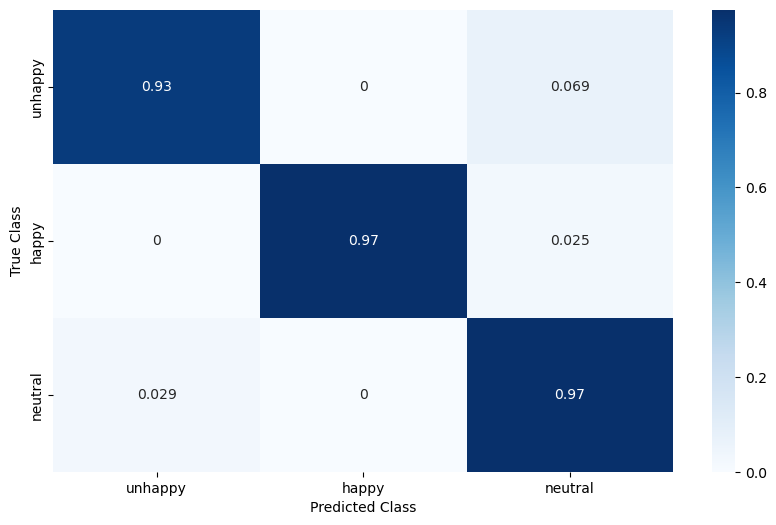

In [62]:
get_report(model=enet_b0_based, validloader=ER_validloader)

### train report

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       285
           1       1.00      0.99      1.00       168
           2       0.93      0.96      0.94       278

    accuracy                           0.95       731
   macro avg       0.96      0.96      0.96       731
weighted avg       0.96      0.95      0.95       731

accuracy: 0.955


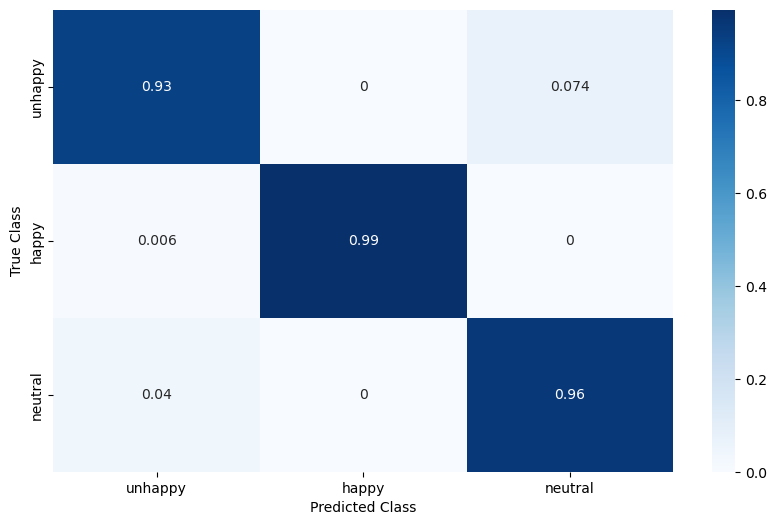

In [63]:
get_report(model=enet_b0_based, validloader=ER_trainloader)

## EfficientNet-B2

In [23]:
loss_trace = []

for epoch in tqdm(range(epochs)):
    if epoch in range(9):
        print(f'epoch №0{epoch+1} is currently running...')
    else:
        print(f'epoch №{epoch+1} is currently running...')
        
    epoch_loss = train_one_epoch(model=enet_b2_based, criterion=criterion, optimizer=enet_b2_based_optimizer,
        trainloader=ER_trainloader)
    
    if epoch % 5 == 0:
        validate_one_epoch(model=enet_b2_based, criterion=criterion, validloader=ER_validloader)
    
    loss_trace.append(epoch_loss)
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

epoch №01 is currently running...
train evaluations: f1: 0.637, accuracy: 0.639, precision (micro): 0.639, recall (micro): 0.639, loss: 0.856
validation evaluations: f1: 0.888, accuracy: 0.879, precision (micro): 0.879, recall (micro): 0.879, loss: 0.611

epoch №02 is currently running...
train evaluations: f1: 0.869, accuracy: 0.854, precision (micro): 0.854, recall (micro): 0.854, loss: 0.563

epoch №03 is currently running...
train evaluations: f1: 0.854, accuracy: 0.839, precision (micro): 0.839, recall (micro): 0.839, loss: 0.463

epoch №04 is currently running...
train evaluations: f1: 0.878, accuracy: 0.862, precision (micro): 0.862, recall (micro): 0.862, loss: 0.408

epoch №05 is currently running...
train evaluations: f1: 0.881, accuracy: 0.866, precision (micro): 0.866, recall (micro): 0.866, loss: 0.370

epoch №06 is currently running...
train evaluations: f1: 0.885, accuracy: 0.871, precision (micro): 0.871, recall (micro): 0.871, loss: 0.359
validation evaluations: f1: 0.

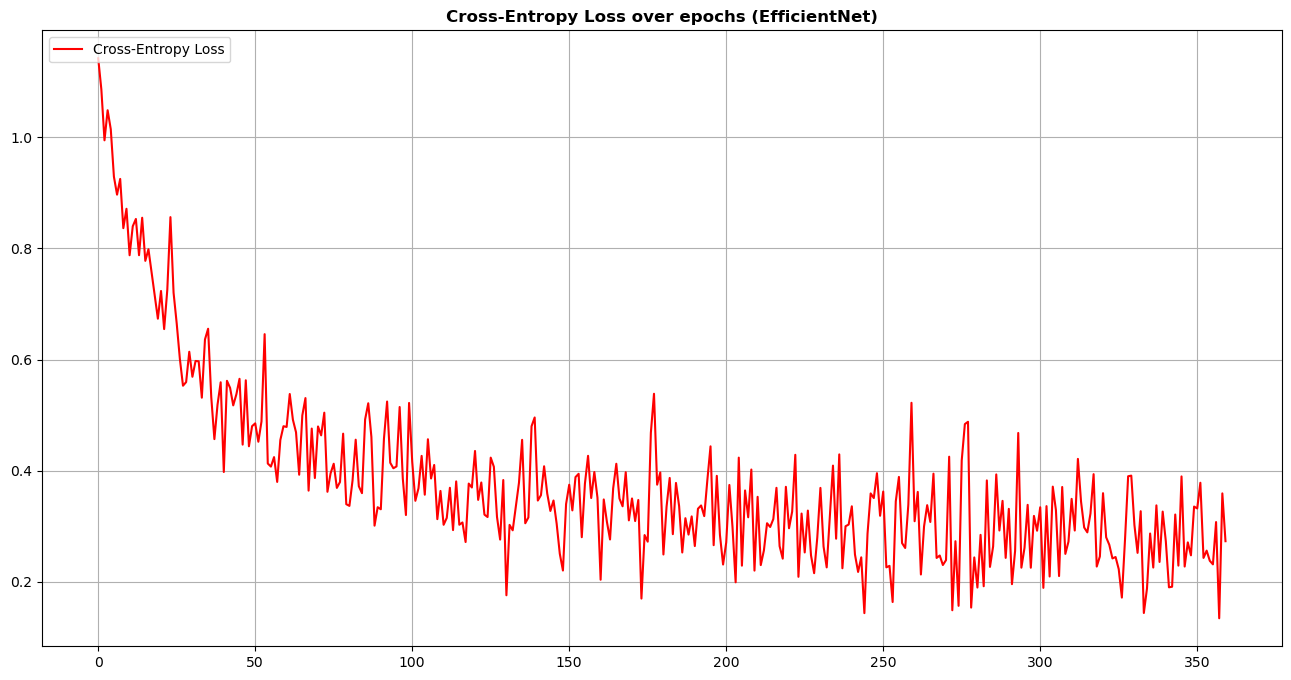

In [24]:
plot_loss(loss_trace=loss_trace, model_name=enet_b2_based.model.__class__.__name__)

### validation report

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       1.00      1.00      1.00        40
           2       0.88      0.90      0.89        70

    accuracy                           0.91       182
   macro avg       0.92      0.92      0.92       182
weighted avg       0.91      0.91      0.91       182

accuracy: 0.912


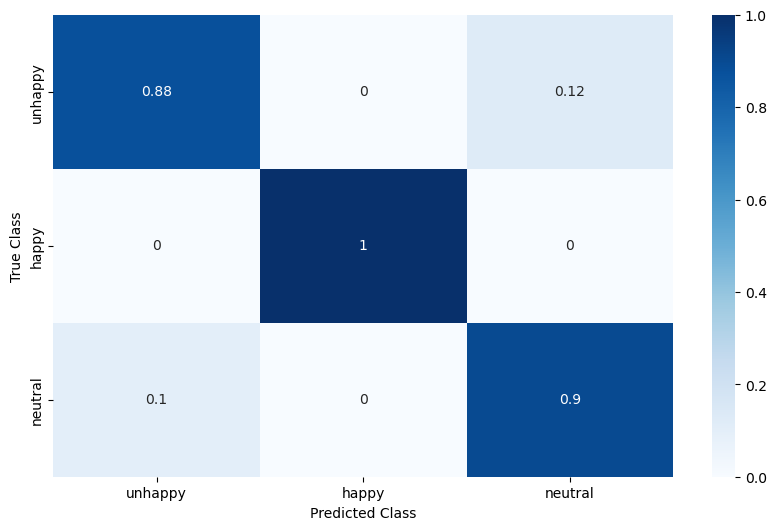

In [25]:
get_report(model=enet_b2_based, validloader=ER_validloader)

### train report

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       285
           1       0.98      0.99      0.98       168
           2       0.85      0.89      0.87       278

    accuracy                           0.89       731
   macro avg       0.90      0.91      0.91       731
weighted avg       0.89      0.89      0.89       731

accuracy: 0.893


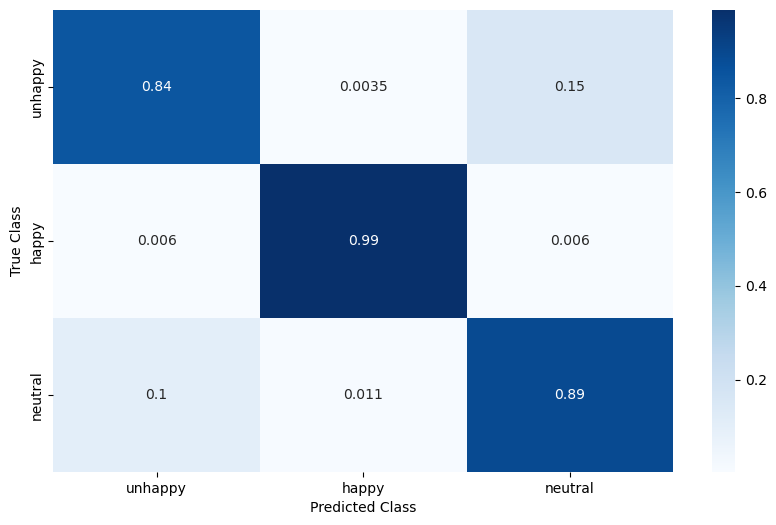

In [26]:
get_report(model=enet_b2_based, validloader=ER_trainloader)

# save models

In [29]:
torch.save(enet_b0_based.state_dict(), models_dir+'/'+'enetb0_without_surprised.pt')
torch.save(enet_b2_based.state_dict(), models_dir+'/'+'enetb2_without_surprised.pt')

# save classifiers

In [30]:
enet_b0_classifier_params = enet_b0_based.classifier.state_dict()
torch.save(enet_b0_classifier_params, models_dir+'/'+'enetb0_classifier.pt')
enet_b2_classifier_params = enet_b2_based.classifier.state_dict()
torch.save(enet_b2_classifier_params, models_dir+'/'+'enetb2_classifier.pt')